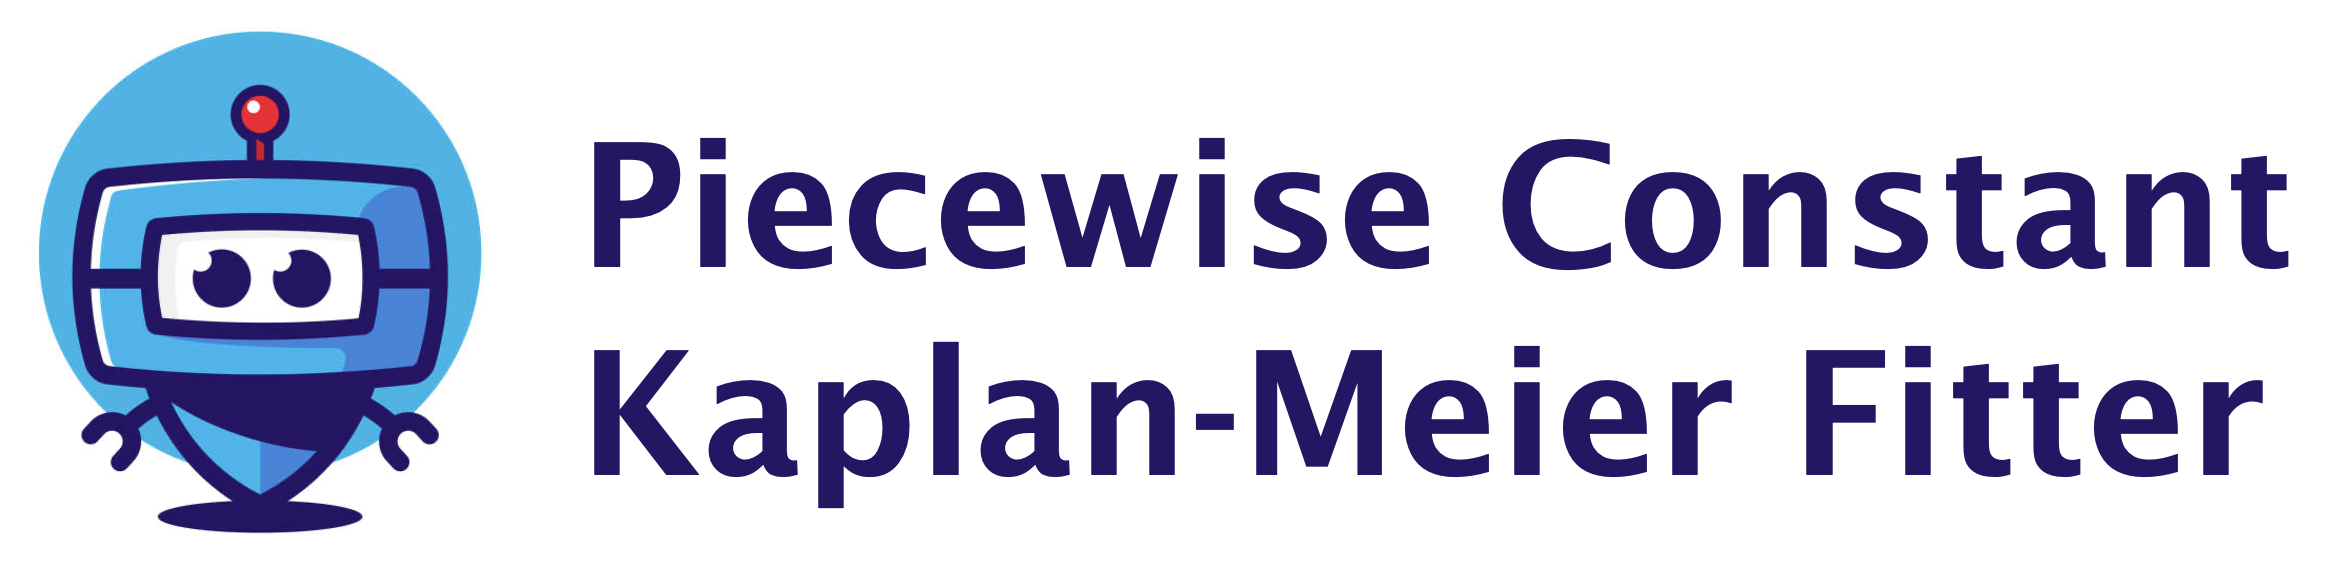

This script provides functionality to fit a Kaplan-Meier curve with N-piecewise constant hazard segments. Essentially, the script allows the user to break the KM-curve into different time periods, and fit an exponential model to each section.

**Inputs:**
1.   **Upload a CSV data file** that contains two columns (time and event). Where event is either observed (1) or censored (0). NEVER UPLOAD CONFIDENTIAL COMPANY DATA.
2.   **Key in the number of constant hazard segements you'd like to fit**. An optimizer will return the best fit values.

**How to use:**
*   Execute each code chunk from top to bottom in sequence by clicking the play icon.
*   Choose and upload the CSV when prompted.



In [ ]:
## If you're running the script the first time, you'll need to install
## Should take <10 seconds
!pip install lifelines
!pip install pwlf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 10.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b38d42bf1dd69b682f2b34f38634d9f9aab1a321715a834e8d982e973ad85953
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pwlf: filename=pwlf-2.2.1-py3-none-any.whl size=16610 sha256=9e1239c87d397bb5f4f40a62fe19a68a4680acbdf9fbcc0c210aef8f54f7e98f
  Stored in directory: /root/.cache/pip/wheels/d9/13/6f/a9201ce279d71065ce782d82418d7c6877be6bb818ae0d1095
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18167 sha256=e988e4ea1717bc124effe60ef52df422b0cc3727c15509bab10fb823b120e1d1
  Stored

In [ ]:
## load libraries
import pandas as pd
import numpy as np
from google.colab import files
import io
from matplotlib import pyplot as plt
from lifelines import PiecewiseExponentialFitter, NelsonAalenFitter, KaplanMeierFitter, ExponentialFitter
import pwlf

In [ ]:
uploaded = files.upload()

Saving km_data_raw.csv to km_data_raw.csv


In [ ]:
# ===== EDIT START ========
## recommend to not user more than 6 constant segments
## fewer is better for explainability and compute time
num_segments = 6 # Replace with your desired number of constant hazard sections
# ===== EDIT END ==========
if (num_segments <= 0 or num_segments is None or num_segments > 7):
  raise ValueError("Error: Only 1 to 7 segments are allowed.")

In [ ]:
## compute the best fit for the provided number of constant hazard sections
file_name = list(uploaded.keys())
df = pd.read_csv(io.BytesIO(uploaded[file_name[0]]))
T = "time"
E = "event"

## compute log-transformed survival
x = df[T].tolist()
kmf = KaplanMeierFitter().fit(df[T], df[E])
y = kmf.survival_function_
surv = list()

for elem in x:
  surv.append(y['KM_estimate'][elem])
log_surv = 1 + np.log(surv)

t = pd.DataFrame(x, columns=['time'])
surv = pd.DataFrame(surv, columns=['surv'])
log_surv = pd.DataFrame(log_surv, columns=['log_surv'])
dF = pd.concat([t, surv, log_surv], axis=1)

## fit piecewise linear to log-transformed survival
my_pwlf = pwlf.PiecewiseLinFit(dF['time'], dF['log_surv'])
breaks = my_pwlf.fit(num_segments)
break_points = [round(elem, 1) for elem in breaks[1:-1].tolist()]
print(f"Best fit break points: {break_points}")

Best fit break points: [2.5, 11.2, 22.1, 30.0, 43.2]


Hazard rates (left) plot should be monotonically decreasing. A staircase downward. If that is not the case, you are likely overfitting and should reduce the number of constant hazard segements.

<lifelines.PiecewiseExponentialFitter:"PiecewiseExponential_estimate", fitted with 582 total observations, 74 right-censored observations>
   number of observations = 582
number of events observed = 508
           log-likelihood = -1953.27
               hypothesis = lambda_0_ != 1, lambda_1_ != 1, lambda_2_ != 1, lambda_3_ != 1, lambda_4_ != 1, lambda_5_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_0_  15.56       1.67            12.29            18.83
lambda_1_  15.15       1.03            13.13            17.18
lambda_2_  17.06       1.49            14.14            19.99
lambda_3_  21.64       3.25            15.28            28.01
lambda_4_  42.56       8.20            26.48            58.63
lambda_5_ 221.80     220.92          -211.18           654.79

            cmp to     z      p   -log2(p)
lambda_0_     1.00  8.73 <0.005      58.39
lambda_1_     1.00 13.70 <0.005     139.42
lambda_2_     1.00 10.76 <0.005      87.28
lambda_3_     1.00  6.35 <0.005      32.16
lambda_4_     1.00  5.07 <0.005      21.24
lambda_5_     1.00  1.00   0.32       1.65
---
AIC = 3918.54

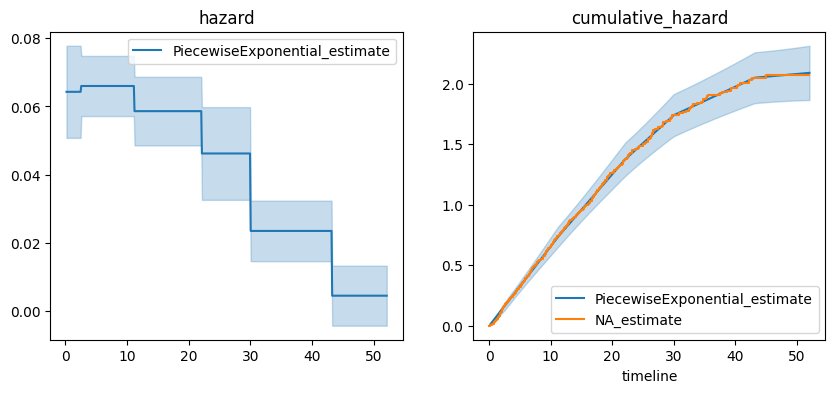

In [ ]:
## applies best-fit break points to PWE fitter
if (break_points):
  fit_obj = PiecewiseExponentialFitter(breakpoints=break_points).fit(df[T], df[E])
else:
  fit_obj = ExponentialFitter().fit(df[T], df[E])

naf = NelsonAalenFitter().fit(df[T], df[E])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax = fit_obj.plot(ax=axs[1])
fit_obj.plot_hazard(ax=axs[0])

ax = naf.plot(ax=ax, ci_show=False)
axs[0].set_title("hazard"); axs[1].set_title("cumulative_hazard")

fit_obj.print_summary()

In [ ]:
from pandas.io.formats import printing
hazard_rates = []

for i in range(num_segments):
  if (break_points):
    method_name = f"lambda_{i}_"
    hazard_rates.append(getattr(fit_obj, method_name, None))
  else:
    method_name =f"lambda_"
    hazard_rates.append(getattr(fit_obj, method_name, None))

hazard_rates = [round(elem, 2) for elem in hazard_rates]
print(f"Best fit hazard rate(s): {hazard_rates}")

def is_monotonically_increasing(lst):
    return all(x < y for x, y in zip(lst, lst[1:]))

result = is_monotonically_increasing(hazard_rates)

if result:
  print("Hazard is monotonically decreasing.")
else:
  print("Error: Hazards are NOT monotonically decreasing.")

Best fit hazard rate(s): [15.56, 15.15, 17.06, 21.64, 42.56, 221.8]
Error: Hazards are NOT monotonically decreasing.


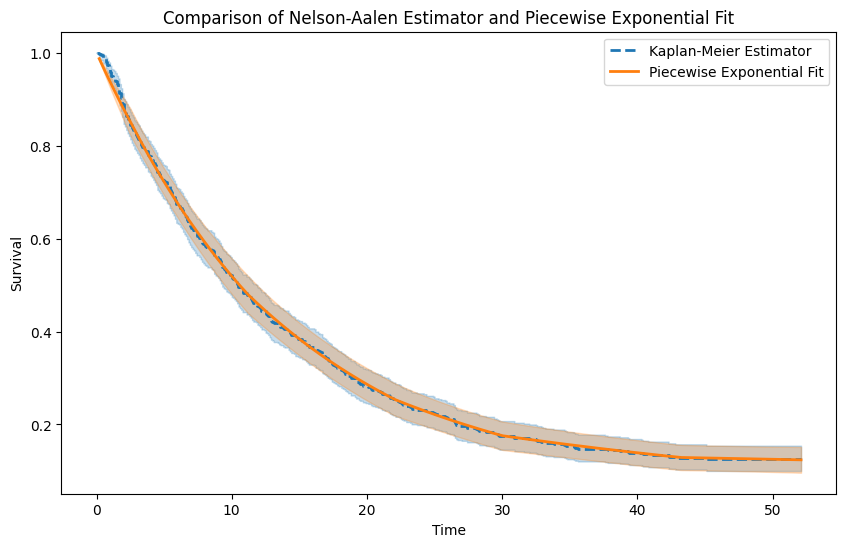

In [ ]:
## visualize the final fit result
plt.figure(figsize=(10, 6))

kmf.plot_survival_function(label="Kaplan-Meier Estimator", linestyle="--", lw=2)
fit_obj.plot_survival_function(label="Piecewise Exponential Fit", linestyle="-", lw=2)

# Set the y-axis scale from 0 to 1
ax.set_ylim(0, 1)

plt.xlabel("Time")
plt.ylabel("Survival")
plt.title("Comparison of Nelson-Aalen Estimator and Piecewise Exponential Fit")
plt.legend()

plt.show()